In [22]:
import math
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
#from pyro.contrib.examples.bart import load_bart_od
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps
from pyro.infer.reparam import LinearHMMReparam, StableReparam, SymmetricStableReparam
from pyro.ops.tensor_utils import periodic_repeat
from pyro.ops.stats import quantile
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
assert pyro.__version__.startswith('1.9.1')
pyro.set_rng_seed(20200305)


In [23]:
games_df = pd.read_csv('../processed_data/games_filtered.csv')

In [24]:
games_df['home_team_name']

0            Bears
1            Bills
2       Buccaneers
3         Patriots
4         Steelers
           ...    
2555       Jaguars
2556          Rams
2557        Ravens
2558        Texans
2559      Seahawks
Name: home_team_name, Length: 2560, dtype: object

In [25]:
games_df.drop(columns = ['weekly_attendance_ratio'], inplace=True)

In [26]:
home_df = games_df.loc[(games_df['home_team_name'] == 'Giants')].copy()

In [27]:
home_df

,year,home_team_name,date,weekly_attendance,prev_game_attendance,home_team_superbowl_winner_last_season,away_team_superbowl_winner_last_season,home_team_playoffs_last_season,away_team_playoffs_last_season,home_team_wins_last_3,...,zscore_turnovers_away,day_sin,day_cos,month_sin,month_cos,noon,mid_afternoon,late_afternoon,evening,avg_season_attendance_prev
8,2010,Giants,September 12,77245.0,78809.0,False,False,False,False,1.0,...,1.519425,-0.781831,0.62349,0.000000,1.000000,True,False,False,False,78701.875
32,2010,Giants,September 26,78386.0,77245.0,False,False,False,False,1.0,...,-1.445802,-0.781831,0.62349,0.000000,1.000000,True,False,False,False,78701.875
60,2010,Giants,October 3,77716.0,78386.0,False,False,False,False,1.0,...,0.471084,-0.781831,0.62349,0.951057,0.309017,False,False,True,False,78701.875
83,2010,Giants,October 17,78341.0,77716.0,False,False,False,False,2.0,...,0.268122,-0.781831,0.62349,0.951057,0.309017,True,False,False,False,78701.875
141,2010,Giants,November 14,80851.0,78341.0,False,False,False,True,3.0,...,-0.160632,-0.781831,0.62349,0.587785,-0.809017,False,True,False,False,78701.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2401,2019,Giants,October 20,73577.0,75041.0,False,False,False,False,1.0,...,-1.258591,-0.781831,0.62349,0.951057,0.309017,True,False,False,False,76940.625
2437,2019,Giants,November 4,76107.0,73577.0,False,False,False,True,0.0,...,0.834364,0.000000,1.00000,0.587785,-0.809017,False,False,True,False,76940.625
2483,2019,Giants,December 1,75950.0,76107.0,False,False,False,False,0.0,...,-1.097888,-0.781831,0.62349,-0.587785,-0.809017,True,False,False,False,76940.625
2515,2019,Giants,December 15,72894.0,75950.0,False,False,False,False,0.0,...,-0.346325,-0.781831,0.62349,-0.587785,-0.809017,True,False,False,False,76940.625


In [28]:
home_df[['month','day']] = home_df['date'].str.split(' ', expand=True).rename(columns={0: 'month', 1: 'day'})

In [29]:
home_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 8 to 2554
Data columns (total 34 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   year                                    80 non-null     int64  
 1   home_team_name                          80 non-null     object 
 2   date                                    80 non-null     object 
 3   weekly_attendance                       80 non-null     float64
 4   prev_game_attendance                    80 non-null     float64
 5   home_team_superbowl_winner_last_season  80 non-null     bool   
 6   away_team_superbowl_winner_last_season  80 non-null     bool   
 7   home_team_playoffs_last_season          80 non-null     bool   
 8   away_team_playoffs_last_season          80 non-null     bool   
 9   home_team_wins_last_3                   80 non-null     float64
 10  away_team_wins_last_3                   80 non-null     float64
 11

In [30]:
16/80

0.2

In [31]:
home_df.loc[home_df['year']>=2018]

,year,home_team_name,date,weekly_attendance,prev_game_attendance,home_team_superbowl_winner_last_season,away_team_superbowl_winner_last_season,home_team_playoffs_last_season,away_team_playoffs_last_season,home_team_wins_last_3,...,day_cos,month_sin,month_cos,noon,mid_afternoon,late_afternoon,evening,avg_season_attendance_prev,month,day
2054,2018,Giants,September 9,77992.0,76269.0,False,False,False,True,1.0,...,0.623490,0.000000,1.000000,True,False,False,False,77179.250,September,9
2109,2018,Giants,September 30,78213.0,77992.0,False,False,False,True,1.0,...,0.623490,0.000000,1.000000,False,True,False,False,77179.250,September,30
2126,2018,Giants,October 11,77167.0,78213.0,False,True,False,True,1.0,...,-0.900969,0.951057,0.309017,False,False,True,False,77179.250,October,11
2159,2018,Giants,October 28,77537.0,77167.0,False,False,False,False,0.0,...,0.623490,0.951057,0.309017,True,False,False,False,77179.250,October,28
2199,2018,Giants,November 18,75863.0,77537.0,False,False,False,False,1.0,...,0.623490,0.587785,-0.809017,True,False,False,False,77179.250,November,18
2228,2018,Giants,December 2,76465.0,75863.0,False,False,False,False,2.0,...,0.623490,-0.587785,-0.809017,True,False,False,False,77179.250,December,2
2264,2018,Giants,December 16,74538.0,76465.0,False,False,False,True,2.0,...,0.623490,-0.587785,-0.809017,True,False,False,False,77179.250,December,16
2290,2018,Giants,December 30,77750.0,74538.0,False,False,False,False,1.0,...,0.623490,-0.587785,-0.809017,True,False,False,False,77179.250,December,30
2323,2019,Giants,September 15,74569.0,77750.0,False,False,False,False,0.0,...,0.623490,0.000000,1.000000,True,False,False,False,76940.625,September,15
2357,2019,Giants,September 29,74149.0,74569.0,False,False,False,False,1.0,...,0.623490,0.000000,1.000000,True,False,False,False,76940.625,September,29


In [32]:
# # Convert month names to numeric values
# month_mapping = {
#     "January": 1, "February": 2, "March": 3, "April": 4, "May": 5, "June": 6,
#     "July": 7, "August": 8, "September": 9, "October": 10, "November": 11, "December": 12
# }
# home_df['month'] = home_df['month'].map(month_mapping)

# # Now convert to datetime
# home_df['date'] = pd.to_datetime(home_df[['year', 'month', 'day']])

In [33]:
games_df.columns

Index(['year', 'home_team_name', 'date', 'weekly_attendance',
       'prev_game_attendance', 'home_team_superbowl_winner_last_season',
       'away_team_superbowl_winner_last_season',
       'home_team_playoffs_last_season', 'away_team_playoffs_last_season',
       'home_team_wins_last_3', 'away_team_wins_last_3', 'pts_home',
       'pts_away', 'yds_home', 'yds_away', 'turnovers_home', 'turnovers_away',
       'zscore_pts_home', 'zscore_yds_home', 'zscore_turnovers_home',
       'zscore_pts_away', 'zscore_yds_away', 'zscore_turnovers_away',
       'day_sin', 'day_cos', 'month_sin', 'month_cos', 'noon', 'mid_afternoon',
       'late_afternoon', 'evening', 'avg_season_attendance_prev'],
      dtype='object')

In [34]:
train_df = home_df.loc[(home_df['year'] < 2018)]

In [35]:
class TransitionNet(torch.nn.Module):
    def __init__(self, cov_dim, hidden_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(cov_dim, 16)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(16, hidden_dim * hidden_dim)
        # self.softmax = torch.nn.Softmax(dim=3)
        self.hidden_dim = hidden_dim

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x= self.fc2(x)
        batch_size = x.size(0)
        
        x = x.view(batch_size, self.hidden_dim, self.hidden_dim)  # [batch, hidden_dim, hidden_dim]
        temperature = 1.5  # try values between 1 and 2
        trans_matrix = torch.nn.functional.softmax(x/ temperature, dim=-1)  # Row-wise softmax for valid transition matrices
        
        # Optional: blend with identity for numerical stability
        # trans_matrix = 0.9 * x + 0.1 * torch.eye(self.hidden_dim)
        return trans_matrix
class Model1(ForecastingModel):
    def __init__(self, cov_dim, num_emission_components=5, hidden_dim=3):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.cov_dim = cov_dim
        self.num_emission_components = num_emission_components
        self.trans_net = TransitionNet(cov_dim, hidden_dim)
        
        # Networks for emission distribution parameters
        self.emission_means = torch.nn.Parameter(torch.randn(hidden_dim, 1))
        self.emission_scales = torch.nn.Parameter(torch.exp(torch.randn(hidden_dim, 1) - 1))


    def model(self, zero_data, covariates):
        duration = zero_data.size(-2)
        batch_shape = zero_data.shape[:-2] 
        hidden_dim = self.hidden_dim
        
        
        # Use last year's average as base prediction
        last_year_avg_attendance = covariates[..., 0]
        other_covariates = covariates[..., 1:]

        prediction = last_year_avg_attendance.unsqueeze(-1)  # [T, 1] or [N, T, 1]
        prediction = prediction.expand_as(zero_data)
        
        # Controls the noise scale in state transitions
        trans_scale = pyro.sample("trans_scale", dist.LogNormal(-0.5 * math.log(24), 1))
        trans_scale = trans_scale + 1e-3
        batch_shape = trans_scale.shape[:-1]  # [N, T]
        init_dist = dist.Normal(0, 10).expand(batch_shape + (hidden_dim,)).to_event(1)

        # Controls the noise scale in observations
        trans_mean = torch.zeros_like(trans_scale)
        trans_dist = dist.Normal(trans_mean, trans_scale).expand(batch_shape + (hidden_dim,)).to_event(1)
        obs_scale = pyro.sample("obs_scale", dist.LogNormal(-2, 1))
        obs_mean = torch.zeros_like(obs_scale)
        obs_dist = dist.Normal(obs_mean, obs_scale).expand(batch_shape + (1,)).to_event(1)
        
        
        # Generate concentration parameters from covariates
        alpha_params = self.trans_net(other_covariates)
        alpha_params = alpha_params.view(duration, hidden_dim, hidden_dim)
        alpha_params = torch.abs(alpha_params) + 1.0  # Ensure positive concentration parameters
        
        # Sample transition matrices from Dirichlet
        has_batch = len(batch_shape) > 0
    
        if has_batch:
            # For forecasting (batch mode), use deterministic transition matrix
            # by normalizing alpha parameters directly
            trans_matrix = alpha_params / alpha_params.sum(dim=-1, keepdim=True)
            trans_matrix = trans_matrix.unsqueeze(0).expand(batch_shape[0], duration, hidden_dim, hidden_dim)
        else:
            # For training (non-batch mode), sample from Dirichlet as before
            trans_matrix = torch.zeros_like(alpha_params)
            for t in range(duration):
                for k in range(hidden_dim):
                    trans_matrix[t, k] = pyro.sample(
                        f"trans_matrix_{t}_{k}",
                        dist.Dirichlet(alpha_params[t, k])
                    )
            obs_matrix = torch.eye(hidden_dim, 1).expand(*batch_shape, hidden_dim, 1)
          
        if batch_shape:
            #trans_matrix = trans_matrix.unsqueeze(0).expand((batch_shape[0], duration, hidden_dim, hidden_dim))
            obs_matrix = torch.eye(hidden_dim, 1).reshape(1, 1, hidden_dim, 1)  # e.g. [1, 1, 3, 1]
            obs_matrix = obs_matrix.expand(batch_shape[0], duration, hidden_dim, 1)  # match batch

            # loc = torch.zeros(batch_shape[0], duration, hidden_dim)
            # scale = torch.full_like(loc, 10.0)
            # init_dist = dist.Normal(loc, scale).to_event(1)
            init_loc = torch.zeros(batch_shape[0], hidden_dim)  # [100, 3]
            init_scale = torch.full((batch_shape[0], hidden_dim), 10.0)  # [100, 3]
            init_dist = dist.Normal(init_loc, init_scale).to_event(1)  # batch_shape [100]

            trans_loc = torch.zeros(batch_shape[0], duration, hidden_dim)
            trans_scale = torch.full_like(trans_loc, 1.0)  # or your current trans_scale value

            trans_dist = dist.Normal(trans_loc, trans_scale).to_event(1)

            # obs_scale = obs_scale.view(batch_shape[0], 1, 1)
            # obs_scale = obs_scale.expand((batch_shape[0], duration, 1))
            # obs_mean = torch.zeros_like(obs_scale)
            # obs_mean = obs_mean.squeeze(-1)         # shape: [100, 32]
            # obs_scale = obs_scale.squeeze(-1)     # shape: [100, 32]   
            obs_scale = obs_scale.view(batch_shape[0], 1, 1).expand(batch_shape[0], duration, 1)
            obs_mean = torch.zeros_like(obs_scale)  # shape [100, 32, 1]
            obs_dist = dist.Normal(obs_mean, obs_scale).to_event(1)  # now event_shape = (1,)
            # obs_dist = dist.Normal(obs_mean, obs_scale) # no to_event here

            # print("transmatrix done")
            # print("trans_matrix shape: ", trans_matrix.shape)
            # print("obs_matrix shape:", obs_matrix.shape)
            # print("obs_dist shape:", obs_dist.shape)
            # print("init dist shape:", init_dist.shape)
            # print("trans dist shape", trans_dist.shape)

        # print(" ")
        # print("trans_matrix shape: ",  trans_matrix.shape[:-2])
        # print("obs_matrix shape:", obs_matrix.shape[:-2])
        # print("obs_dist shape:", obs_dist.batch_shape)
        # print("init dist shape:", init_dist.batch_shape + (1,))
        # print("init_dist.event_shape:", init_dist.event_shape)
        # print("trans dist shape", trans_dist.batch_shape)
        noise_dist = dist.GaussianHMM(
            initial_dist=init_dist,
            transition_matrix=trans_matrix,
            transition_dist=trans_dist,
            observation_matrix=obs_matrix,  # obs_dim = 1
            observation_dist=obs_dist,
            duration=duration
        )

        self.predict(noise_dist, prediction)


# State-Space Model with Dirichlet Transition Matrix Implementation

This code implements a probabilistic state-space model using PyTorch and Pyro, specifically a customized Gaussian Hidden Markov Model (HMM). The model is designed to make predictions based on historical data and additional covariates.

## Key Components and Flow

### Data Preparation
The function takes two inputs: `zero_data` (the observed time series data) and `covariates` (explanatory variables). It extracts the time duration and batch dimensions from the data. Importantly, the model uses the first covariate column as "last year's average attendance," which serves as a baseline prediction.

### Parameter Sampling
The model samples two key stochastic parameters:
- `trans_scale`: Controls the noise scale in state transitions (sampled from a LogNormal distribution)
- `obs_scale`: Controls the noise scale in observations (also sampled from a LogNormal)

These stochastic parameters are part of what makes this a Bayesian model, allowing uncertainty quantification.

### Transition Matrix Construction
A notable feature is the construction of the transition matrix:
1. The model feeds the covariates (except for the first column) through a neural network (`self.trans_net`)
2. The output logits are reshaped into a transition matrix
3. The matrix is regularized by adding a weighted identity component: `0.9 * trans_matrix_raw + 0.1 * torch.eye(hidden_dim)`

This approach, referenced in the comment "Change to Dirichlet transition matrix," suggests the transition probabilities are being modeled in a way inspired by Dirichlet distributions, offering flexibility in how states evolve over time.

### Batch Handling
The code contains extensive logic to handle batched inputs, reshaping distributions and matrices accordingly when batch dimensions are present. This allows the model to process multiple time series simultaneously.

### HMM Construction and Prediction
Finally, the model constructs a `GaussianHMM` using the defined components and calls a `predict` method with the HMM and baseline prediction. The HMM integrates the initial state distribution, transition dynamics, and observation model into a cohesive probabilistic framework.

This implementation represents a sophisticated approach to time series modeling that combines traditional state-space models with neural network components and Bayesian inference.

In [36]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
covariates = train_df[['avg_season_attendance_prev', 'home_team_superbowl_winner_last_season',
       'away_team_superbowl_winner_last_season',
       'home_team_playoffs_last_season', 'away_team_playoffs_last_season',
       'home_team_wins_last_3', 'away_team_wins_last_3', 'pts_home',
       'pts_away', 'yds_home', 'yds_away', 'turnovers_home', 'turnovers_away',
       'zscore_pts_home', 'zscore_yds_home', 'zscore_turnovers_home',
       'zscore_pts_away', 'zscore_yds_away', 'zscore_turnovers_away',
       'day_sin', 'day_cos', 'month_sin', 'month_cos', 'noon', 'mid_afternoon',
       'late_afternoon', 'evening']]
# print(covariates)
covariates.loc[:,['noon', 'mid_afternoon',
       'late_afternoon', 'evening', 'home_team_superbowl_winner_last_season',
       'away_team_superbowl_winner_last_season',
       'home_team_playoffs_last_season', 'away_team_playoffs_last_season']] = covariates[['noon', 'mid_afternoon',
       'late_afternoon', 'evening', 'home_team_superbowl_winner_last_season',
       'away_team_superbowl_winner_last_season',
       'home_team_playoffs_last_season', 'away_team_playoffs_last_season']].astype(bool).astype('int32')

covariates_tensor = torch.tensor(covariates.values, dtype=torch.float)

y = train_df.loc[train_df.index, 'weekly_attendance']
y_tensor = torch.tensor(y.values, dtype=torch.float).unsqueeze(-1)

forecaster = Forecaster(Model1(cov_dim=26, hidden_dim=3), y_tensor, covariates_tensor, learning_rate=0.05, num_steps=150)
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

<timed exec>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 0 1 0 1 1 1 0 1 1 1 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1
 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
<timed exec>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
<timed exec>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0]' has dtype incompatible with

trans_scale = 36.35
obs_scale = 1.49
CPU times: total: 6min 18s
Wall time: 1min 51s


In [37]:
test_and_context_df = home_df.loc[(home_df['year'] >= 2017)]


C:\Users\edgar\AppData\Local\Temp\ipykernel_8980\3208690922.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  covariates_test.loc[:,['noon', 'mid_afternoon',
C:\Users\edgar\AppData\Local\Temp\ipykernel_8980\3208690922.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  covariates_test.loc[:,['noon', 'mid_afternoon',
C:\Users\edgar\AppData\Local\Temp\ipykernel_8980\3208690922.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0]' has dtype incompatib

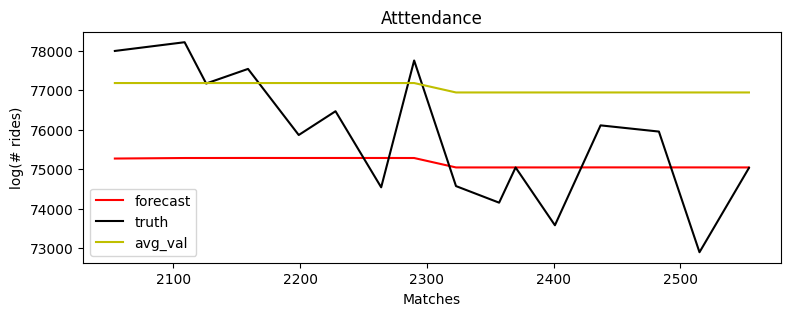

In [38]:
# covariates_test_with_test = torch.zeros(T2-T0, 0)  # empty
covariates_test = test_and_context_df[['avg_season_attendance_prev', 'home_team_superbowl_winner_last_season',
       'away_team_superbowl_winner_last_season',
       'home_team_playoffs_last_season', 'away_team_playoffs_last_season',
       'home_team_wins_last_3', 'away_team_wins_last_3', 'pts_home',
       'pts_away', 'yds_home', 'yds_away', 'turnovers_home', 'turnovers_away',
       'zscore_pts_home', 'zscore_yds_home', 'zscore_turnovers_home',
       'zscore_pts_away', 'zscore_yds_away', 'zscore_turnovers_away',
       'day_sin', 'day_cos', 'month_sin', 'month_cos', 'noon', 'mid_afternoon',
       'late_afternoon', 'evening']]
# print(covariates_test)
covariates_test.loc[:,['noon', 'mid_afternoon',
       'late_afternoon', 'evening', 'home_team_superbowl_winner_last_season',
       'away_team_superbowl_winner_last_season',
       'home_team_playoffs_last_season', 'away_team_playoffs_last_season']] = covariates_test[['noon', 'mid_afternoon',
       'late_afternoon', 'evening', 'home_team_superbowl_winner_last_season',
       'away_team_superbowl_winner_last_season',
       'home_team_playoffs_last_season', 'away_team_playoffs_last_season']].astype(bool).astype('int32')

covariates_test_tensor = torch.tensor(covariates_test.values, dtype=torch.float)

y_context = test_and_context_df.loc[test_and_context_df['year']<2018, 'weekly_attendance']
y_context_tensor = torch.tensor(y_context.values, dtype=torch.float).unsqueeze(-1)
samples = forecaster(y_context_tensor, covariates_test_tensor, num_samples=100)
# samples.clamp_(min=0)  # apply domain knowledge: the samples must be positive
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
y_test = test_and_context_df.loc[test_and_context_df['year']>=2018, 'weekly_attendance']
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float).unsqueeze(-1)
crps = eval_crps(samples, y_test_tensor)

plt.figure(figsize=(9, 3))
# plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(y_test.index, p50, 'r-', label='forecast')
plt.plot(y_test.index, y_test.values, 'k-', label='truth')
plt.plot(y_test.index, covariates_test.loc[y_test.index,'avg_season_attendance_prev'].values, 'y', label='avg_val')
plt.title("Atttendance")
plt.ylabel("log(# rides)")
plt.xlabel("Matches")
plt.legend(loc="best")


In [39]:
y_test.shape

(16,)

In [40]:
print(home_df.loc[home_df['year']==2017, 'weekly_attendance'].values.mean())
home_df.loc[home_df['year']==2018, 'avg_season_attendance_prev']

77179.25


2054    77179.25
2109    77179.25
2126    77179.25
2159    77179.25
2199    77179.25
2228    77179.25
2264    77179.25
2290    77179.25
Name: avg_season_attendance_prev, dtype: float64

In [41]:
att_df = pd.read_csv('../original_data/attendance.csv')    

In [42]:
att_df.loc[att_df['team_name'] == 'Cardinals']

,team,team_name,year,total,home,away,week,weekly_attendance
0,Arizona,Cardinals,2000,893926,387475,506451,1,77434.0
1,Arizona,Cardinals,2000,893926,387475,506451,2,66009.0
2,Arizona,Cardinals,2000,893926,387475,506451,3,NaN
3,Arizona,Cardinals,2000,893926,387475,506451,4,71801.0
4,Arizona,Cardinals,2000,893926,387475,506451,5,66985.0
...,...,...,...,...,...,...,...,...
10314,Arizona,Cardinals,2019,1000509,490586,509923,13,60944.0
10315,Arizona,Cardinals,2019,1000509,490586,509923,14,63880.0
10316,Arizona,Cardinals,2019,1000509,490586,509923,15,63345.0
10317,Arizona,Cardinals,2019,1000509,490586,509923,16,69022.0


In [43]:
games_df

,year,home_team_name,date,weekly_attendance,prev_game_attendance,home_team_superbowl_winner_last_season,away_team_superbowl_winner_last_season,home_team_playoffs_last_season,away_team_playoffs_last_season,home_team_wins_last_3,...,zscore_turnovers_away,day_sin,day_cos,month_sin,month_cos,noon,mid_afternoon,late_afternoon,evening,avg_season_attendance_prev
0,2010,Bears,September 12,62080.0,62479.0,False,False,False,False,2.0,...,0.268122,-0.781831,0.62349,0.000000,1.000000,True,False,False,False,62250.000
1,2010,Bills,September 12,69295.0,69848.0,False,False,False,False,1.0,...,-1.196211,-0.781831,0.62349,0.000000,1.000000,True,False,False,False,67808.125
2,2010,Buccaneers,September 12,47211.0,62578.0,False,False,False,False,2.0,...,0.696191,-0.781831,0.62349,0.000000,1.000000,True,False,False,False,65649.250
3,2010,Patriots,September 12,68756.0,68756.0,False,False,False,True,2.0,...,0.346325,-0.781831,0.62349,0.000000,1.000000,True,False,False,False,68756.000
4,2010,Steelers,September 12,63609.0,64068.0,False,False,False,False,3.0,...,-0.514384,-0.781831,0.62349,0.000000,1.000000,True,False,False,False,63485.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555,2019,Jaguars,December 29,58472.0,57866.0,False,False,False,True,1.0,...,0.412861,-0.781831,0.62349,-0.587785,-0.809017,False,True,False,False,69073.625
2556,2019,Rams,December 29,68665.0,71501.0,False,False,False,False,1.0,...,2.337384,-0.781831,0.62349,-0.587785,-0.809017,False,True,False,False,72429.875
2557,2019,Ravens,December 29,70695.0,70545.0,False,False,False,False,3.0,...,0.230361,-0.781831,0.62349,-0.587785,-0.809017,False,True,False,False,70431.375
2558,2019,Texans,December 29,71794.0,71769.0,False,False,False,False,2.0,...,-0.980426,-0.781831,0.62349,-0.587785,-0.809017,False,True,False,False,71804.875


In [44]:
print(y_test)

2054    77992.0
2109    78213.0
2126    77167.0
2159    77537.0
2199    75863.0
2228    76465.0
2264    74538.0
2290    77750.0
2323    74569.0
2357    74149.0
2370    75041.0
2401    73577.0
2437    76107.0
2483    75950.0
2515    72894.0
2554    75029.0
Name: weekly_attendance, dtype: float64


In [45]:
#test_df

In [46]:
class Model1(ForecastingModel):
    def __init__(self, cov_dim, hidden_dim=3):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.cov_dim = cov_dim
        self.trans_net = TransitionNet(cov_dim, hidden_dim)

    def model(self, zero_data, covariates):
        duration = zero_data.size(-2)
        batch_shape = zero_data.shape[:-2]  # This should be [100] when sampling
        
        hidden_dim = self.hidden_dim
        last_year_avg_attendance = covariates[..., 0]
        other_covariates = covariates[..., 1:]
        
        # Mean function - ensure proper broadcasting
        prediction = last_year_avg_attendance.unsqueeze(-1).expand_as(zero_data)
        print(batch_shape)
        print("zero_data shape:", zero_data.shape)
        # Priors - allp expanded to batch_shape + hidden_dim
        init_dist = dist.Normal(0, 10).expand(batch_shape + (hidden_dim,)).to_event(1)
        
        # Sample with proper batch_shape
        trans_scale = pyro.sample(
            "trans_scale", 
            dist.LogNormal(-0.5 * math.log(24), 1)
            .expand(batch_shape)
        ).unsqueeze(-1)  # Add hidden_dim dimension
        
        trans_dist = dist.Normal(
            torch.zeros(batch_shape + (hidden_dim,)),
            trans_scale.expand(batch_shape + (hidden_dim,))
        ).to_event(1)
        
        obs_scale = pyro.sample(
            "obs_scale",
            dist.LogNormal(-2, 1)
            .expand(batch_shape)
        ).unsqueeze(-1)  # Add observation dimension
        
        obs_dist = dist.Normal(
            torch.zeros(batch_shape + (1,)),
            obs_scale
        ).to_event(1)

        # Generate transition matrices - handle batch dimension properly
        # Reshape covariates to merge sample and time dimensions
        orig_shape = other_covariates.shape
        other_covariates_reshaped = other_covariates.reshape(-1, orig_shape[-1])
        
        # Process through network
        trans_logits = self.trans_net(other_covariates_reshaped)
        
        # Reshape back to include sample dimension
        trans_matrix = trans_logits.reshape(*batch_shape, duration, hidden_dim, hidden_dim)
        
        # Stability adjustment
        eye = torch.eye(hidden_dim, device=trans_matrix.device)
        trans_matrix = 0.9 * trans_matrix + 0.1 * eye
        
        # Observation matrix - properly expanded
        obs_matrix = torch.eye(hidden_dim, 1, device=trans_matrix.device)
        obs_matrix = obs_matrix.expand(*batch_shape, hidden_dim, 1)
        
        # Build GaussianHMM
        noise_dist = dist.GaussianHMM(
            initial_dist=init_dist,
            transition_matrix=trans_matrix,
            transition_dist=trans_dist,
            observation_matrix=obs_matrix,
            observation_dist=obs_dist,
            duration=duration
        )

        self.predict(noise_dist, prediction)

In [47]:
a = torch.tensor([1.0013e-01, 8.9934e-01, 5.3601e-04])
a.sum()

tensor(1.0000)

In [48]:
torch.softmax(torch.tensor([0.9, -0.1, 4.0]), dim=0)

tensor([0.0424, 0.0156, 0.9420])